# TODO

- using longest responses?

In [1]:
import random
import numpy as np

random.seed(0)
np.random.seed(0)

In [2]:
HUMAN = "human"

GEMINI_10 = "gemini-1.0-pro"
GEMINI_15 = "gemini-1.5-pro-latest"

CLAUDE_SONNET = "claude-3-sonnet-20240229"
CLAUDE_OPUS = "claude-3-opus-20240229"

GPT_35 = "gpt-3.5-turbo-0125"
GPT_40 = "gpt-4-turbo-2024-04-09"


authors = [HUMAN, GEMINI_10, GEMINI_15, CLAUDE_SONNET, CLAUDE_OPUS, GPT_35, GPT_40]

# Function words

In [3]:
with open("function_words/oshea.txt") as f:
    lines = f.readlines()
    fw_oseah = [line.split()[0] for line in lines]

# Z-Scores

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np


class ZScoreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, function_words):
        self.function_words = function_words
        self.vectorizer = TfidfVectorizer(
            use_idf=False, norm=None, tokenizer=word_tokenize, token_pattern=None
        )
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        # Fit the vectorizer to the corpus
        word_counts = self.vectorizer.fit_transform(X).toarray()

        # oov = [
        #    word
        #    for word in self.function_words
        #    if word not in self.vectorizer.vocabulary_
        # print(f"{len(oov)} words not in corpus: {oov}")

        # Fit z-score scaler to the relative frequencies
        relative_freqs = word_counts / word_counts.sum(axis=1, keepdims=True)
        self.scaler.fit(relative_freqs)
        return self

    def transform(self, X):
        # Transform the corpus into word counts
        word_counts = self.vectorizer.transform(X).toarray()

        # Calculate the relative frequencies
        relative_freqs = word_counts / word_counts.sum(axis=1, keepdims=True)

        # Calculate the z-scores
        z_scores = self.scaler.transform(relative_freqs)

        fw_indices = [
            self.vectorizer.vocabulary_[word]
            for word in self.function_words
            if word in self.vectorizer.vocabulary_
        ]

        # Keep the relative frquencies of only the function words
        fw_z_scores = z_scores[:, fw_indices]

        return fw_z_scores

# Deltas

In [5]:
def delta(z_scores, variant):
    if variant == "burrows":
        return cdist(z_scores, z_scores, metric="cityblock")
    if variant == "cosine":
        return cdist(z_scores, z_scores, metric="cosine")

    raise ValueError(f"Unknown variant: {variant}")

# Classification

In [6]:
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


def classify(df, function_words, test_prompts=None, print_n_most_important=None):
    # Train-test split
    prompt_ids = df["prompt_id"].unique().tolist()
    if not test_prompts:
        test_prompts = random.sample(prompt_ids, 2)

    df_test = df[df["prompt_id"].isin(test_prompts)].reset_index(drop=True)
    df_train = df[~df["prompt_id"].isin(test_prompts)].reset_index(drop=True)

    # Use the ZScoreTransformer to get the z-scores
    z_scores_transformer = ZScoreTransformer(function_words)
    z_scores_train = z_scores_transformer.fit_transform(df_train["text"])
    z_scores_test = z_scores_transformer.transform(df_test["text"])

    # Set up cross-validation
    train_indices_by_prompt = (
        df_train.groupby("prompt_id")
        .apply(lambda x: x.index, include_groups=False)
        .tolist()
    )
    cv_iterable = []
    for _ in range(3):
        train_indices_by_prompt = (
            train_indices_by_prompt[2:] + train_indices_by_prompt[:2]
        )
        val_indices = np.concatenate(train_indices_by_prompt[:2])
        train_indices = np.concatenate(train_indices_by_prompt[2:])
        cv_iterable.append((train_indices, val_indices))

    # Train the model using grid search
    model = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid={
            "C": [0.001, 0.003, 0.01, 0.03, 0.1],
            "solver": ["liblinear", "lbfgs"],
        },
        cv=cv_iterable,
        n_jobs=-1,
        refit=True,
    )

    model.fit(z_scores_train, df_train["author"])
    y_pred = model.predict(z_scores_test)

    df_test["y_pred"] = y_pred

    # print the words that were most important for the model
    if print_n_most_important:
        coefs = model.best_estimator_.coef_
        coefs = coefs[0]
        coefs = np.abs(coefs)
        coefs = coefs / coefs.sum()
        fw = np.array(function_words)
        fw = fw[coefs.argsort()[::-1]]
        print(fw[:print_n_most_important])

    return df_test

## Most important words

### Top 10

In [7]:
for dataset in (["reddit"] * 5) + (["hewlett"] * 5):
    df_human = pd.read_csv("reddit_responses/human.csv")
    df_human["author"] = HUMAN
    df_gpt = pd.read_csv("reddit_responses/gpt-3.5-turbo-0125.csv")
    df_gpt["author"] = GPT_35
    df = pd.concat([df_human, df_gpt], ignore_index=True)

    classify(df, fw_oseah, print_n_most_important=10)

['a' 'since' 'it' 'behind' 'under' 'that' 'towards' 'onto' 'the' 'and']
['a' 'over' 'that' 'around' 'its' 'he' 'since' 'against' 'it' 'the']
['a' 'since' 'behind' 'that' 'it' 'nowhere' 'and' 'onto' 'under' 'towards']
['a' 'it' 'since' 'behind' 'that' 'and' 'the' 'under' 'onto' 'than']
['that' 'a' 'than' 'the' 'and' 'behind' 'as' 'hereabouts' 'onto' 'he']
['a' 'than' 'behind' 'that' 'he' 'as' 'the' 'hereabouts' 'often' 'thus']
['that' 'a' 'than' 'the' 'and' 'behind' 'as' 'hereabouts' 'onto' 'he']
['a' 'it' 'toward' 'around' 'outside' 'and' 'that' 'the' 'over' 'may']
['a' 'over' 'that' 'around' 'he' 'its' 'she' 'towards' 'against' 'and']
['a' 'since' 'at' 'that' 'the' 'here' 'thereafter' 'towards' 'he' 'beyond']


### Frequencies: he, she, a, the

In [8]:
for dataset in ["reddit", "hewlett"]:
    print(dataset)
    df_human = pd.read_csv(f"{dataset}_responses/human.csv")
    df_gpt = pd.read_csv(f"{dataset}_responses/gpt-3.5-turbo-0125.csv")

    df_human["tokens"] = df_human["text"].apply(word_tokenize)
    df_gpt["tokens"] = df_gpt["text"].apply(word_tokenize)

    # see the relative frequency of 'he' and 'she' in GPT-3.5 vs human
    words = ["he", "she", "a", "the"]
    for word in words:
        word_rel_freq_gpt = df_gpt["tokens"].apply(lambda x: x.count(word) / len(x))
        word_rel_freq_human = df_human["tokens"].apply(lambda x: x.count(word) / len(x))
        print(
            f"{word}: human: {word_rel_freq_human.mean()} gpt: {word_rel_freq_gpt.mean()}"
        )
    print()

reddit
he: human: 0.006625333485078846 gpt: 0.0021662682621693243
she: human: 0.004413168826978141 gpt: 0.012964098128293942
a: human: 0.014263125695069606 gpt: 0.027195232612212766
the: human: 0.034400312602841265 gpt: 0.06502085149060624

hewlett
he: human: 0.005037284925477697 gpt: 0.001965197994441381
she: human: 0.004390490978073949 gpt: 0.0018364145447078678
a: human: 0.017954408912960206 gpt: 0.022107849185965252
the: human: 0.04745341423057013 gpt: 0.06075187005456569



## Multiclass (all 7 authors)

Running reddit trials: 100%|██████████| 10/10 [04:30<00:00, 27.01s/it]


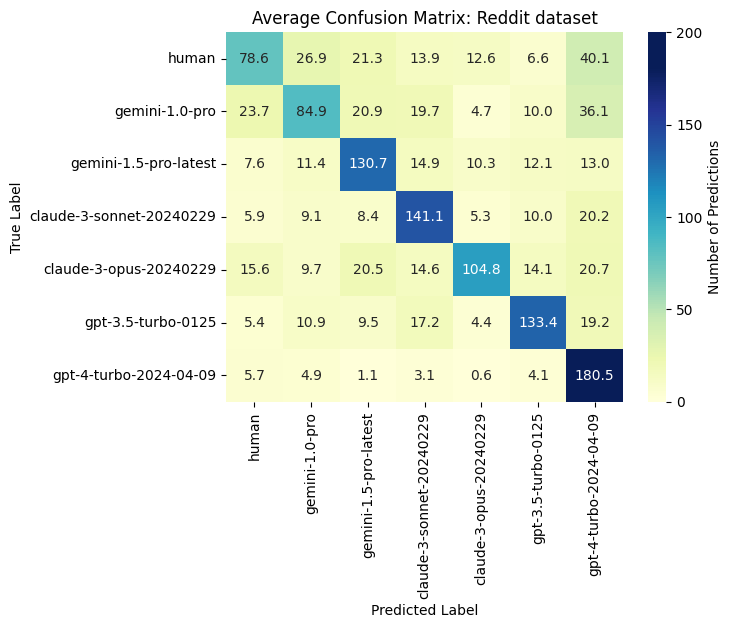

Running hewlett trials: 100%|██████████| 10/10 [04:05<00:00, 24.60s/it]


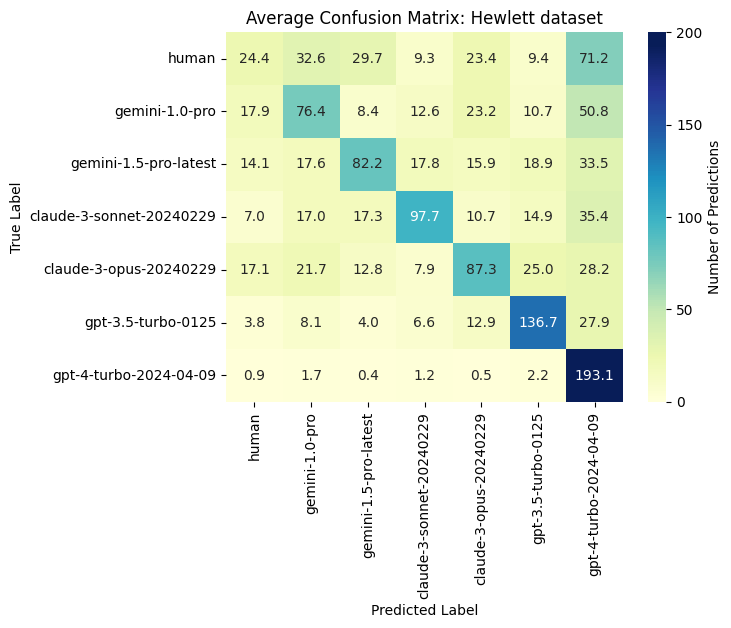

In [9]:
n_trials = 10

for dataset in ["reddit", "hewlett"]:
    dfs = []
    for author in authors:
        df = pd.read_csv(f"{dataset}_responses/{author}.csv")
        df["author"] = author
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)

    avg_conf_matrix = np.zeros((len(authors), len(authors)))
    for _ in tqdm(range(n_trials), desc=f"Running {dataset} trials"):
        df_test = classify(df, fw_oseah)
        conf_matrix = confusion_matrix(df_test["author"], df_test["y_pred"])
        avg_conf_matrix += conf_matrix

    avg_conf_matrix /= n_trials

    sns.heatmap(
        avg_conf_matrix,
        annot=True,
        cmap="YlGnBu",
        fmt=".1f",
        cbar_kws={
            "label": "Number of Predictions",
            "boundaries": np.arange(0, 201, 1),
            "ticks": np.arange(0, 201, 50),
        },
        xticklabels=authors,
        yticklabels=authors,
    )
    plt.title(f"Average Confusion Matrix: {dataset.capitalize()} dataset")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Pairwise with human and each LLM

100%|██████████| 60/60 [08:34<00:00,  8.58s/it]


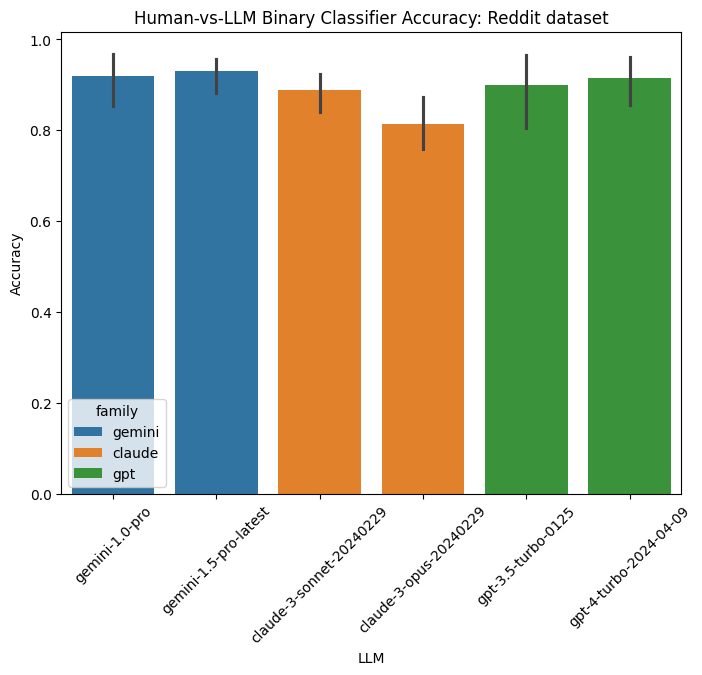

100%|██████████| 60/60 [06:35<00:00,  6.58s/it]


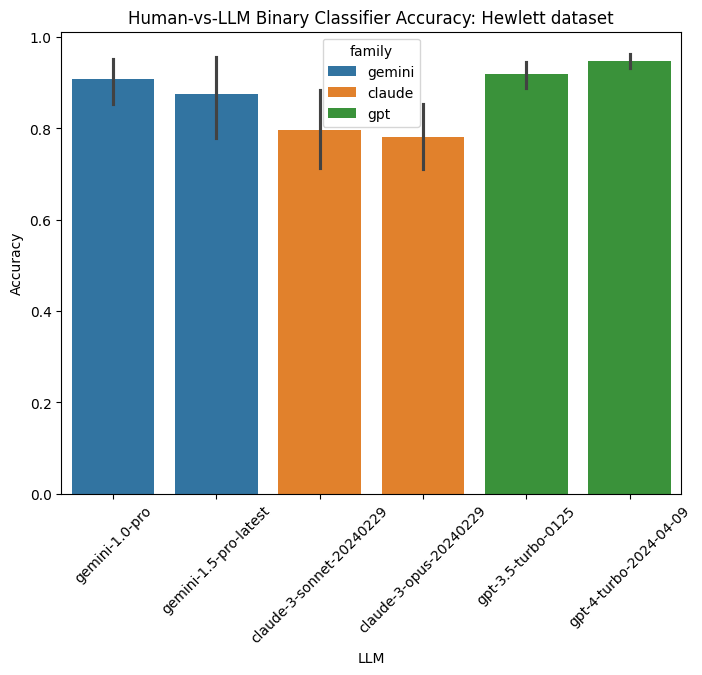

In [10]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

n_trials = 10
llms = [GEMINI_10, GEMINI_15, CLAUDE_SONNET, CLAUDE_OPUS, GPT_35, GPT_40]

for dataset in ["reddit", "hewlett"]:
    results = []
    for llm in tqdm(llms * n_trials):
        df_llm = pd.read_csv(f"{dataset}_responses/{llm}.csv")
        df_llm["author"] = llm
        df_human = pd.read_csv(f"{dataset}_responses/{HUMAN}.csv")
        df_human["author"] = HUMAN
        df = pd.concat([df_llm, df_human], ignore_index=True)

        df_test = classify(df, fw_oseah)
        report = classification_report(
            df_test["author"], df_test["y_pred"], zero_division=0, output_dict=True
        )
        results.append(
            {
                "dataset": dataset,
                "llm": llm,
                "family": llm.split("-")[0],
                "accuracy": report["accuracy"],
            }
        )

    results_df = pd.DataFrame(results)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=results_df, x="llm", y="accuracy", hue="family")
    plt.title(
        f"Human-vs-LLM Binary Classifier Accuracy: {dataset.capitalize()} dataset"
    )
    plt.ylabel("Accuracy")
    plt.xlabel("LLM")
    plt.xticks(rotation=45)
    plt.show()

# Mis-labels: GPT 3.5, human

In [11]:
n_trials = 10

for dataset in ["reddit", "hewlett"]:
    df_human = pd.read_csv(f"{dataset}_responses/human.csv")
    df_human["author"] = HUMAN
    df_gpt_35 = pd.read_csv(f"{dataset}_responses/{GPT_35}.csv")
    df_gpt_35["author"] = GPT_35
    df = pd.concat([df_human, df_gpt_35], ignore_index=True)

    llm_predicted_human = {}
    human_predicted_llm = {}

    for _ in tqdm(range(n_trials)):
        prompts = list(range(8))
        random.shuffle(prompts)
        test_prompts_list = [prompts[:2], prompts[2:4], prompts[4:6], prompts[6:8]]

        for test_prompts in test_prompts_list:
            df_test = classify(df, function_words=fw_oseah, test_prompts=test_prompts)

            for prompt in test_prompts:
                df_human_predicted_llm = df_test[
                    (df_test["author"] == HUMAN)
                    & (df_test["y_pred"] == GPT_35)
                    & (df_test["prompt_id"] == prompt)
                ]
                if not df_human_predicted_llm.empty:
                    llm_predicted_human[prompt] = df_human_predicted_llm.iloc[0]["text"]

                df_llm_predicted_human = df_test[
                    (df_test["author"] == GPT_35)
                    & (df_test["y_pred"] == HUMAN)
                    & (df_test["prompt_id"] == prompt)
                ]
                if not df_llm_predicted_human.empty:
                    human_predicted_llm[prompt] = df_llm_predicted_human.iloc[0]["text"]

    print(f"Dataset: {dataset}")
    for prompt in range(8):
        print(f"Prompt: {prompt}")
        if prompt in llm_predicted_human:
            print(f"Human predicted LLM: {llm_predicted_human[prompt]}")
        else:
            print("Human predicted LLM: N/A")
        if prompt in human_predicted_llm:
            print(f"LLM predicted human: {human_predicted_llm[prompt]}")
        else:
            print("LLM predicted human: N/A")
        print()
    print("\n" * 3)

100%|██████████| 10/10 [05:02<00:00, 30.24s/it]


Dataset: reddit
Prompt: 0
Human predicted LLM: N/A
LLM predicted human: In response to the creative writing prompt, a story can be developed that explores the complex dynamics between the peaceful alien race and humanity. The narrative could delve into the moral dilemmas faced by both sides - the aliens in having to seek aid from a species known for its brutality, and humans in deciding whether to help a civilization in need despite their violent reputation.

The plot could follow the unfolding alliance between the aliens and humans as they work together to fend off the aggressors threatening the peaceful alien race. Through this collaboration, friendships could be formed, cultural exchanges could take place, and understanding between the two species could grow.

Moreover, the development of FTL (faster-than-light) technology could serve as a catalyst for new opportunities and challenges for both civilizations. As the aliens gain access to advanced technology, they may experience progr

100%|██████████| 10/10 [04:10<00:00, 25.07s/it]

Dataset: hewlett
Prompt: 0
Human predicted LLM: N/A
LLM predicted human: [Your Name]
[Your Address]
[City, State, Zip Code]
[Email Address]
[Phone Number]

[Date]

Editor,
[Newspaper Name]
[Address]
[City, State, Zip Code]

Dear Editor,

I am writing to express my opinion on the effects computers have on people and to persuade your readers to consider a balanced perspective on this important issue.

There is no denying that computers and technology have brought about numerous benefits to society. They have revolutionized the way we work, communicate, and learn. Computers teach hand-eye coordination, provide access to a vast amount of information, and allow people to connect with others from all corners of the globe. These advancements have undoubtedly enriched our lives in many ways.

However, it is crucial to acknowledge the potential negative impact that excessive computer use can have on individuals and society as a whole. Spending too much time in front of a screen can lead to sede

## GPT 3.5 Temperatures

100%|██████████| 140/140 [17:35<00:00,  7.54s/it]


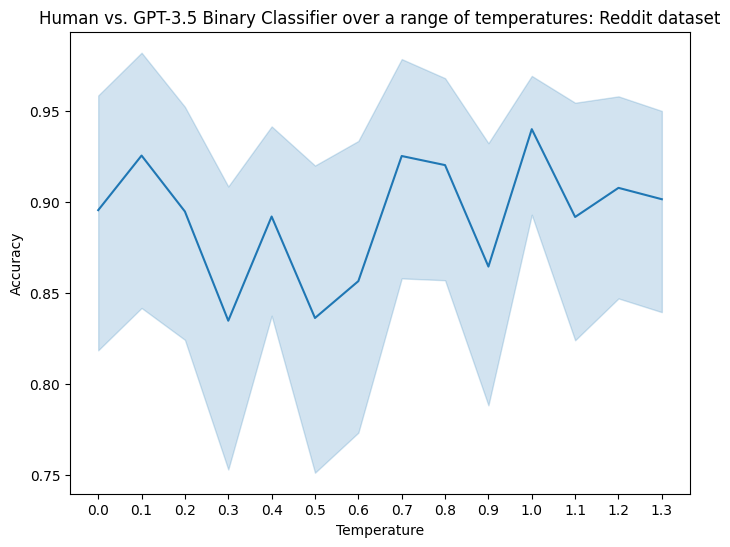

100%|██████████| 140/140 [14:31<00:00,  6.23s/it]


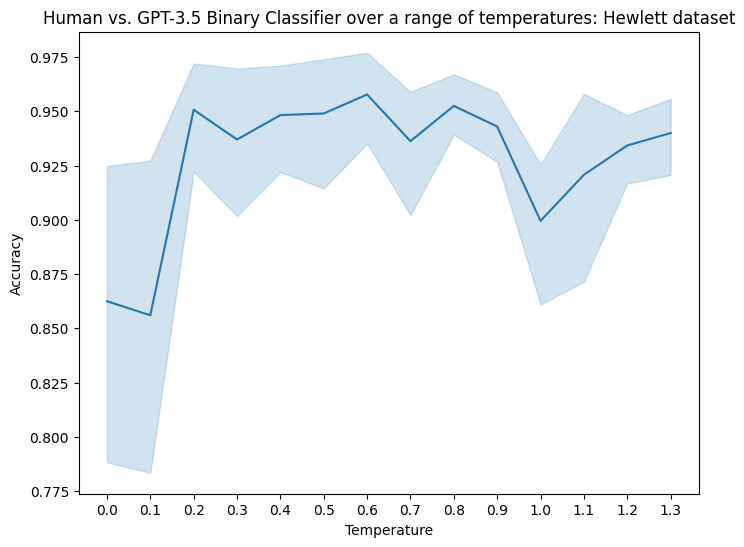

In [12]:
n_trials = 10
temps = [f"{0.1 * i:.1f}" for i in range(14)]

for dataset in ["reddit", "hewlett"]:
    results = []
    for temp in tqdm(temps * n_trials):
        df_human = pd.read_csv(f"{dataset}_responses/human.csv")
        df_human["author"] = HUMAN
        df_temp = pd.read_csv(f"{dataset}_responses/{GPT_35}_{temp}.csv")
        df_temp["author"] = GPT_35
        df = pd.concat([df_human, df_temp], ignore_index=True)

        df_test = classify(df, fw_oseah)
        report = classification_report(
            df_test["author"], df_test["y_pred"], zero_division=0, output_dict=True
        )
        results.append(
            {
                "dataset": dataset,
                "temp": temp,
                "accuracy": report["accuracy"],
            }
        )

    results_df = pd.DataFrame(results)

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x="temp", y="accuracy")
    plt.title(
        f"Human vs. GPT-3.5 Binary Classifier over a range of temperatures: {dataset.capitalize()} dataset"
    )
    plt.ylabel("Accuracy")
    plt.xlabel("Temperature")
    plt.show()

# t-SNE

## All prompts

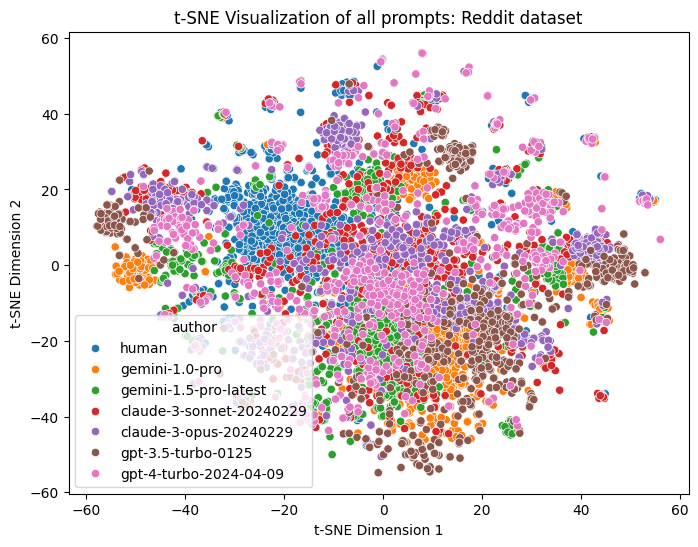

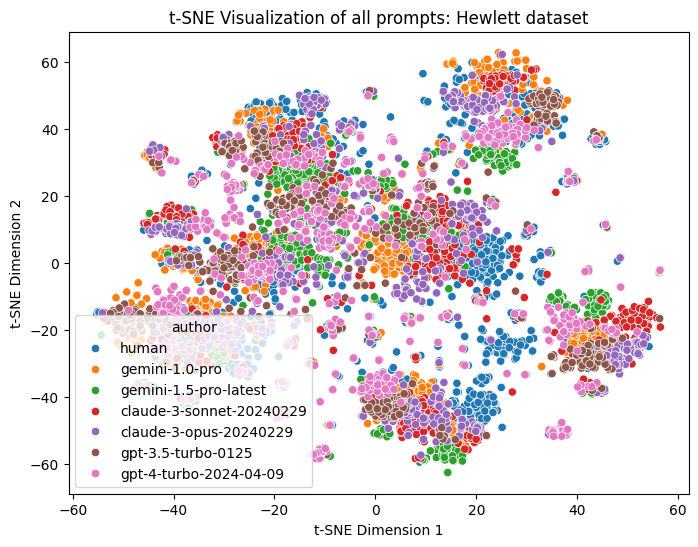

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

for dataset in ["reddit", "hewlett"]:
    dfs = []
    for author in authors:
        df = pd.read_csv(f"{dataset}_responses/{author}.csv")
        df["author"] = author
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)

    z_scores_transformer = ZScoreTransformer(function_words=fw_oseah)
    z_scores = z_scores_transformer.fit_transform(df["text"])

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(z_scores)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["author"])
    plt.title(f"t-SNE Visualization of all prompts: {dataset.capitalize()} dataset")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

## Individual prompts

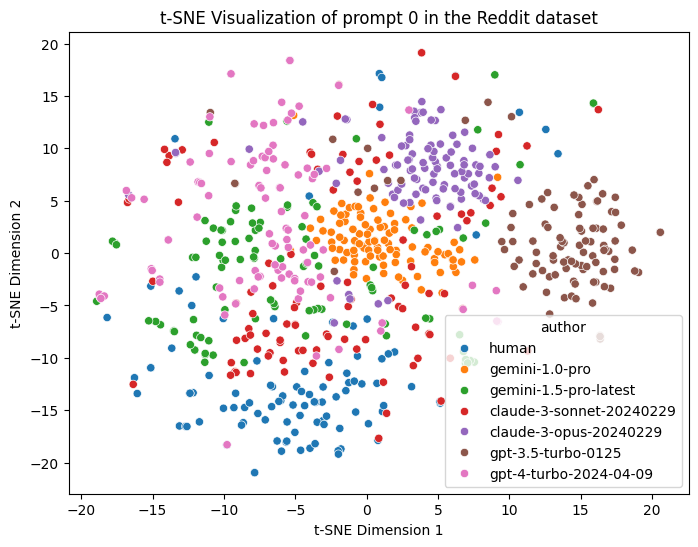

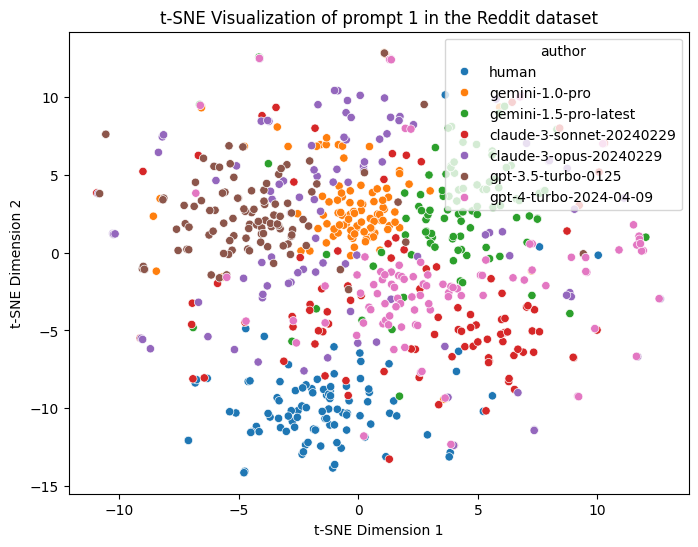

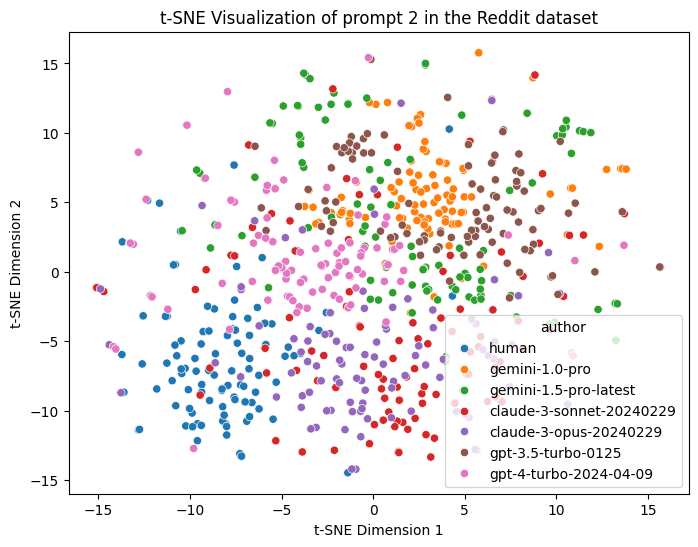

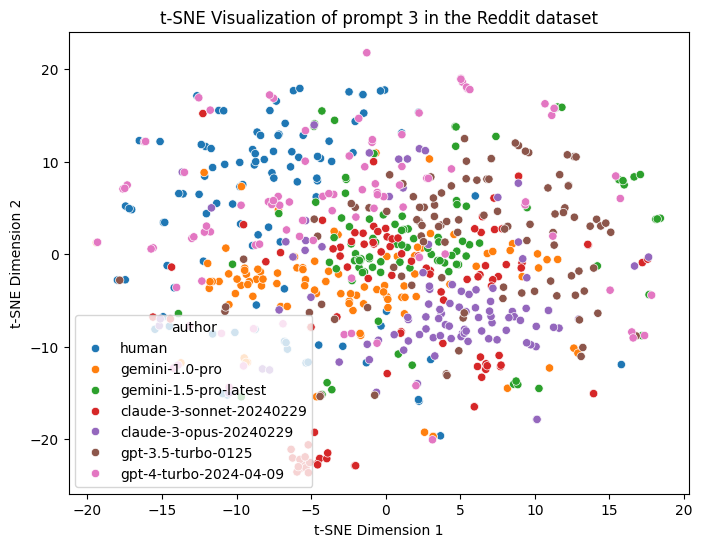

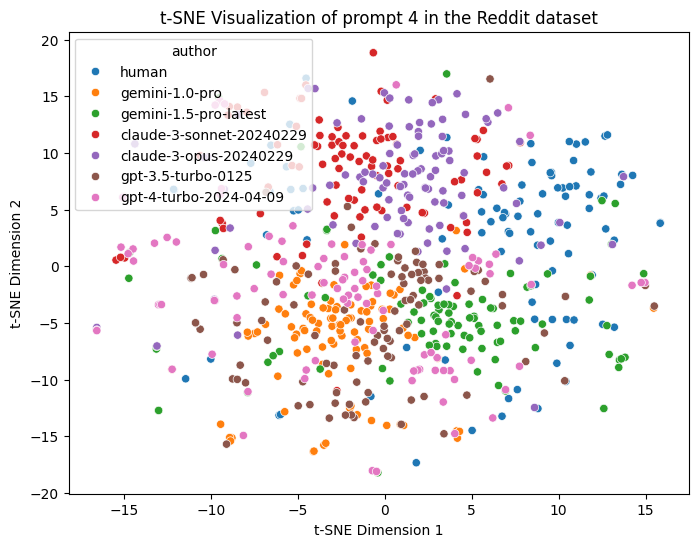

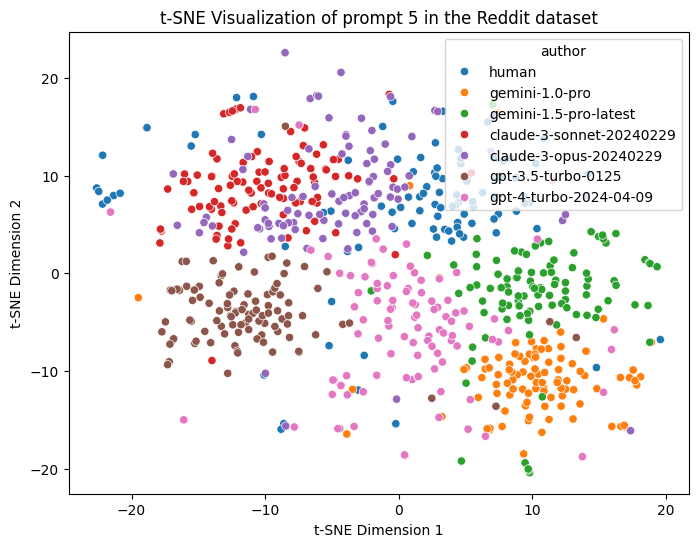

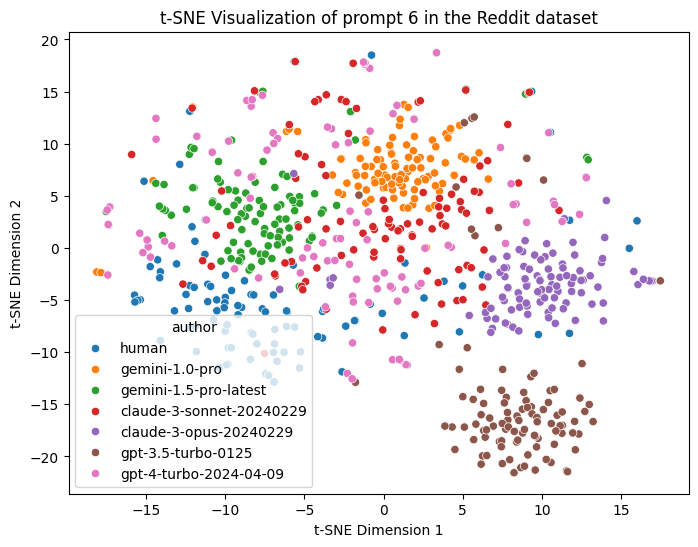

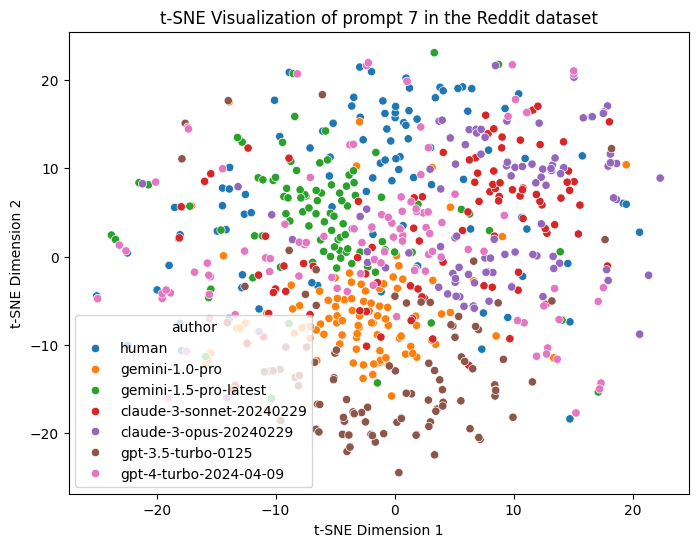

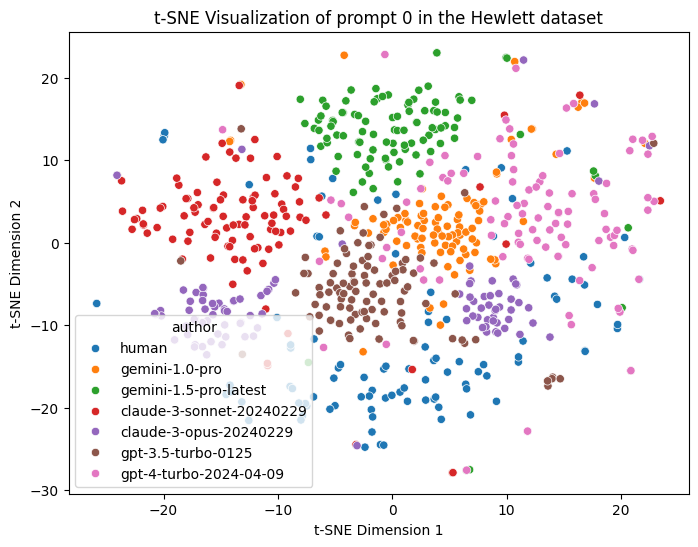

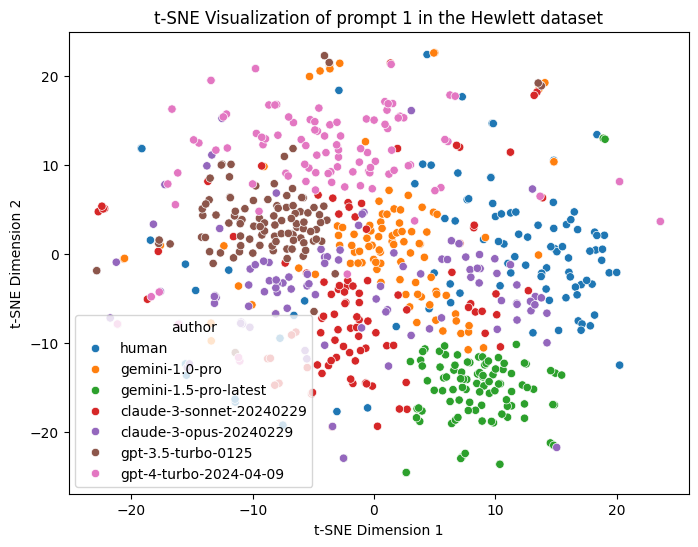

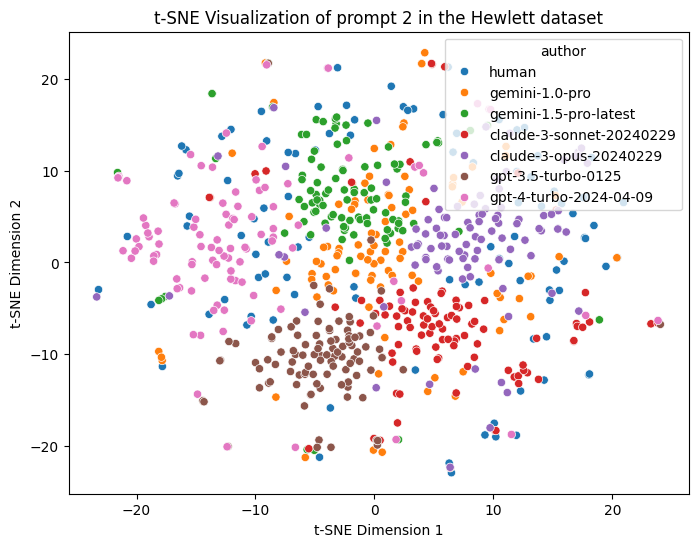

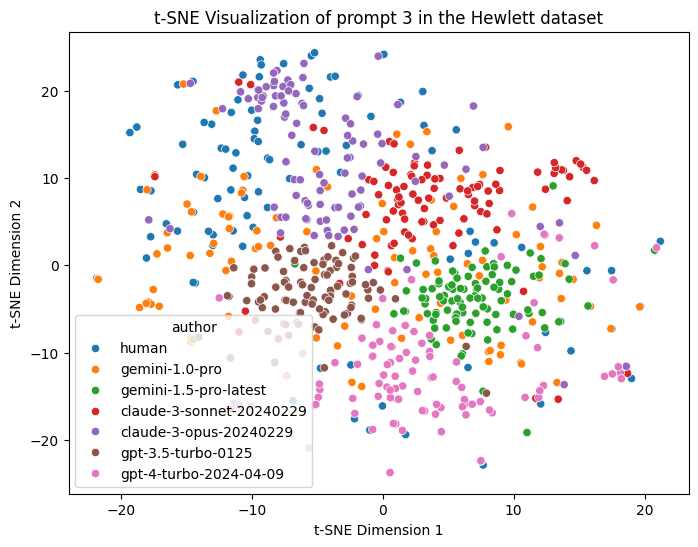

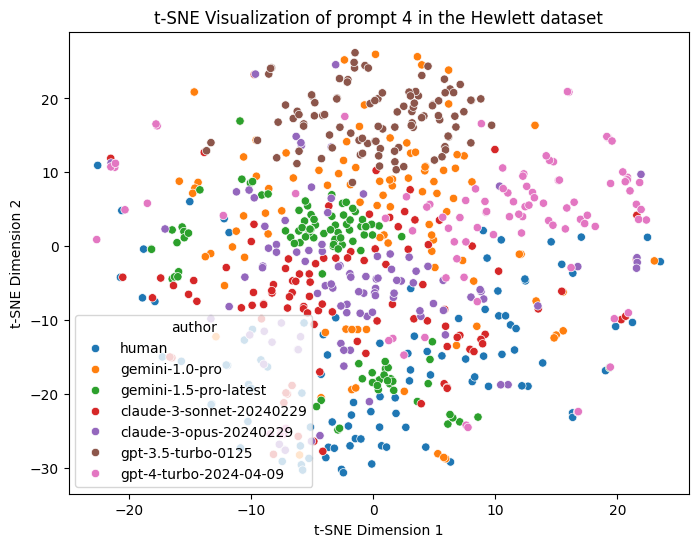

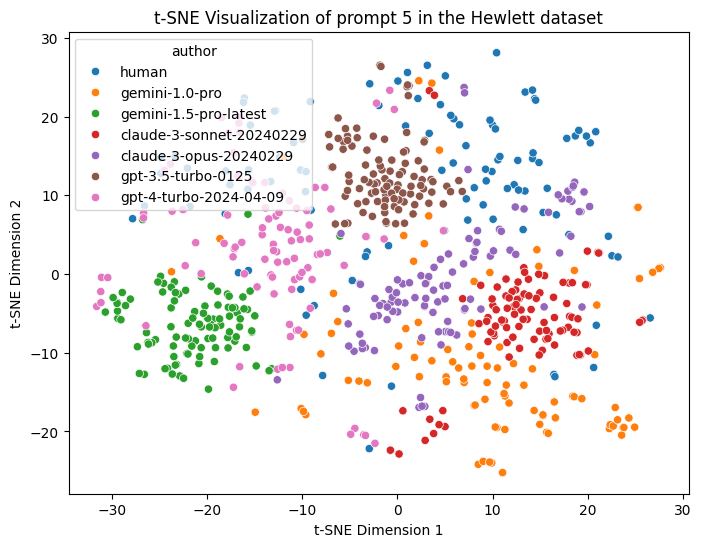

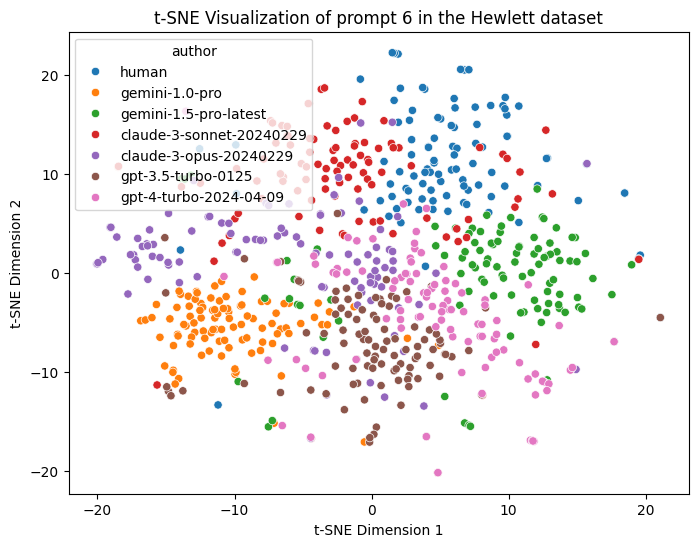

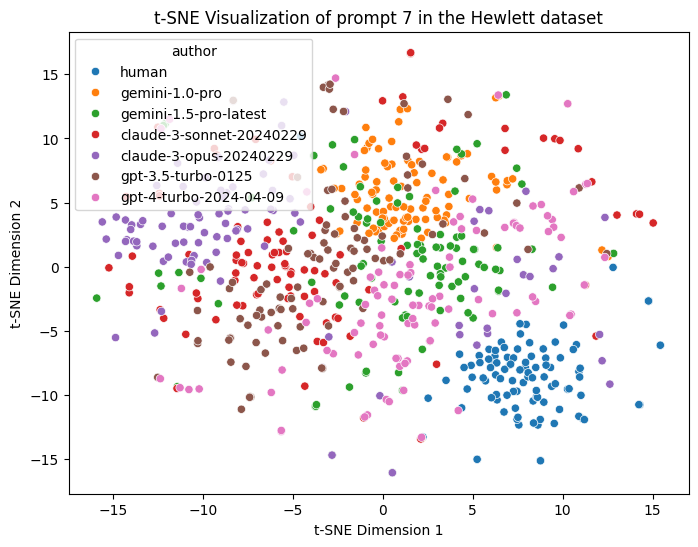

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

for dataset in ["reddit", "hewlett"]:
    for prompt_id in range(8):
        dfs = []
        for author in authors:
            df = pd.read_csv(f"{dataset}_responses/{author}.csv")
            df["author"] = author
            dfs.append(df)
        df = pd.concat(dfs, ignore_index=True)
        df = df[df["prompt_id"] == prompt_id]

        z_scores_transformer = ZScoreTransformer(function_words=fw_oseah)
        z_scores = z_scores_transformer.fit_transform(df["text"])

        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(z_scores)

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["author"])
        plt.title(
            f"t-SNE Visualization of prompt {prompt_id} in the {dataset.capitalize()} dataset"
        )
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.show()